Matplotlib is building the font cache; this may take a moment.


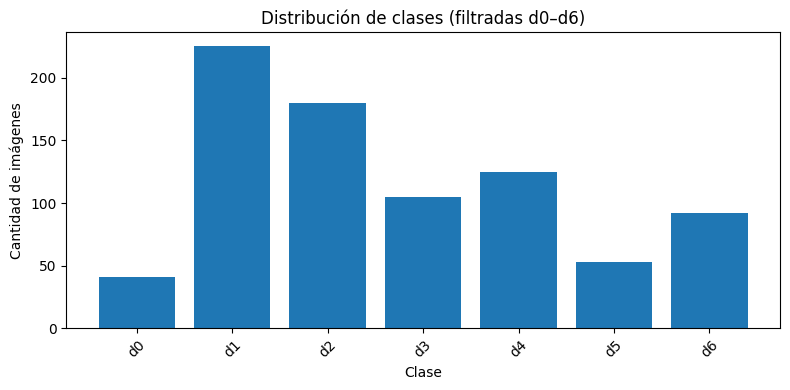

Counter({1: 225, 2: 180, 4: 125, 3: 105, 6: 92, 5: 53, 0: 41})

In [1]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt

# Definir etiquetas válidas: d0 a d6
etiquetas_validas = set(range(7))  # d0 a d6

# Ruta al dataset
img_dir = "img"

# Filtrar archivos con etiquetas válidas
labels = []
filenames_filtrados = []
for filename in os.listdir(img_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        match = re.search(r"_d(\d+)_", filename)
        if match:
            label = int(match.group(1))
            if label in etiquetas_validas:
                labels.append(label)
                filenames_filtrados.append(filename)

# Contar ocurrencias por clase
label_counts = Counter(labels)
sorted_labels = sorted(label_counts.items())
classes, counts = zip(*sorted_labels)

# Graficar distribución de clases filtradas
plt.figure(figsize=(8, 4))
plt.bar([f"d{c}" for c in classes], counts)
plt.title("Distribución de clases (filtradas d0–d6)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar recuento
label_counts


Clases dX: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
Clases oX: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/dilanacosta/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 13.1MB/s]


Época 1/10 - Loss Entrenamiento: 2.1734, Validación: 1.7454
Época 2/10 - Loss Entrenamiento: 0.7274, Validación: 1.3154
Época 3/10 - Loss Entrenamiento: 0.2409, Validación: 1.3181
Época 4/10 - Loss Entrenamiento: 0.0602, Validación: 1.4750
Época 5/10 - Loss Entrenamiento: 0.0180, Validación: 1.4159
Época 6/10 - Loss Entrenamiento: 0.0111, Validación: 1.3942
Época 7/10 - Loss Entrenamiento: 0.0100, Validación: 1.5310
Época 8/10 - Loss Entrenamiento: 0.0057, Validación: 1.5155
Época 9/10 - Loss Entrenamiento: 0.0032, Validación: 1.5029
Época 10/10 - Loss Entrenamiento: 0.0026, Validación: 1.5679
✅ Modelo guardado como 'modelo_ductos_multitarea_efnet.pth'


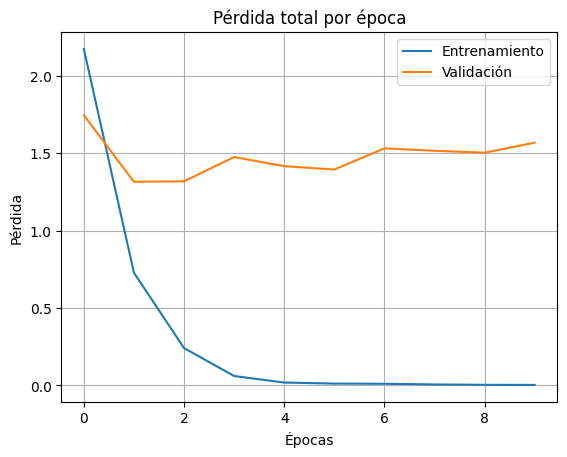


--- Reporte para dX (ductos totales) ---
              precision    recall  f1-score   support

          d0       0.62      0.56      0.59         9
          d1       0.85      0.65      0.74        43
          d2       0.53      0.56      0.54        34
          d3       0.33      0.43      0.38        21
          d4       0.41      0.52      0.46        27
          d5       0.50      0.62      0.55        13
          d6       0.71      0.53      0.61        19
         d7+       0.00      0.00      0.00         2

    accuracy                           0.55       168
   macro avg       0.50      0.48      0.48       168
weighted avg       0.58      0.55      0.56       168


--- Reporte para oX (ductos ocupados) ---
              precision    recall  f1-score   support

          o0       0.64      0.53      0.58        17
          o1       0.69      0.67      0.68        52
          o2       0.50      0.65      0.57        46
          o3       0.28      0.35      0.31    

/Users/dilanacosta/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dilanacosta/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dilanacosta/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

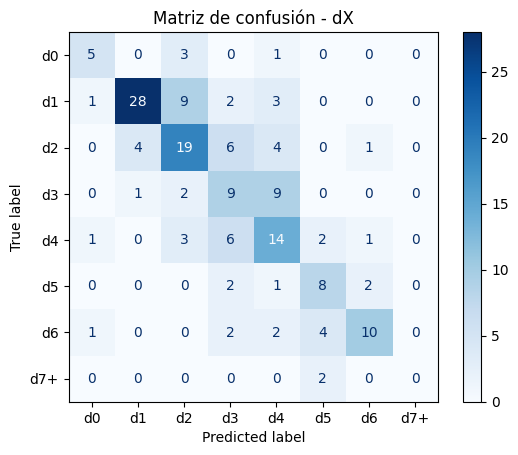

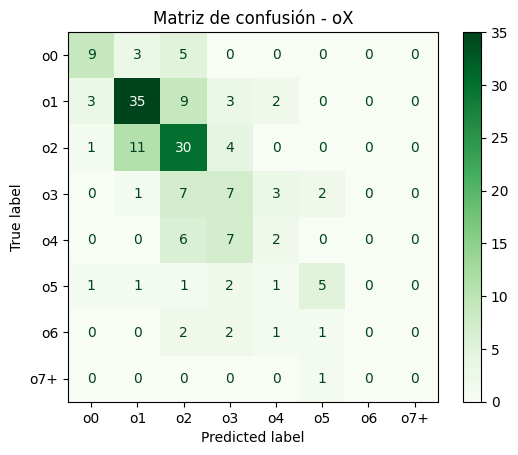

In [7]:
import os, re, random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- Reproducibilidad ---
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# --- Transformaciones ---
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss

# --- Dataset multitarea con clases agrupadas ---
class DuctoDatasetGrouped(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images, self.labels_d, self.labels_o = [], [], []

        for f in os.listdir(img_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                match_d = re.search(r"_d(\d+)_", f)
                match_o = re.search(r"_o(\d+)_", f)
                if match_d and match_o:
                    d = int(match_d.group(1))
                    o = int(match_o.group(1))
                    self.images.append(f)
                    self.labels_d.append(min(d, 7))  # 7+ para dX
                    self.labels_o.append(min(o, 7))  # 7+ para oX

        self.classes_d = sorted(set(self.labels_d))
        self.classes_o = sorted(set(self.labels_o))
        self.class_to_idx_d = {v: i for i, v in enumerate(self.classes_d)}
        self.class_to_idx_o = {v: i for i, v in enumerate(self.classes_o)}
        self.idx_to_class_d = {i: v for v, i in self.class_to_idx_d.items()}
        self.idx_to_class_o = {i: v for v, i in self.class_to_idx_o.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_d = self.class_to_idx_d[self.labels_d[idx]]
        label_o = self.class_to_idx_o[self.labels_o[idx]]
        return image, label_d, label_o

# --- Modelo multitarea EfficientNet ---
class MultiEfficientNet(nn.Module):
    def __init__(self, base_model, num_classes_d, num_classes_o):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifier_d = nn.Linear(base_model.classifier[1].in_features, num_classes_d)
        self.classifier_o = nn.Linear(base_model.classifier[1].in_features, num_classes_o)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)
        out_d = self.classifier_d(x)
        out_o = self.classifier_o(x)
        return out_d, out_o

# --- Preparar datos ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ruta = "img"
dataset = DuctoDatasetGrouped(ruta)

print("Clases dX:", dataset.class_to_idx_d)
print("Clases oX:", dataset.class_to_idx_o)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_ds.dataset.transform = transform_train
val_ds.dataset.transform = transform_val

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- Modelo + Focal Loss ---
base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model = MultiEfficientNet(base, len(dataset.class_to_idx_d), len(dataset.class_to_idx_o)).to(device)

criterion_d = FocalLoss()
criterion_o = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Entrenamiento ---
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x, y_d, y_o in train_loader:
        x, y_d, y_o = x.to(device), y_d.to(device), y_o.to(device)
        optimizer.zero_grad()
        out_d, out_o = model(x)
        loss = criterion_d(out_d, y_d) + criterion_o(out_o, y_o)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y_d, y_o in val_loader:
            x, y_d, y_o = x.to(device), y_d.to(device), y_o.to(device)
            out_d, out_o = model(x)
            loss = criterion_d(out_d, y_d) + criterion_o(out_o, y_o)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Época {epoch+1}/{num_epochs} - Loss Entrenamiento: {train_losses[-1]:.4f}, Validación: {val_losses[-1]:.4f}")

# --- Guardar modelo ---
torch.save(model.state_dict(), "modelo_ductos_multitarea_efnet.pth")
print("✅ Modelo guardado como 'modelo_ductos_multitarea_efnet.pth'")

# --- Gráfico de pérdidas ---
plt.plot(train_losses, label="Entrenamiento")
plt.plot(val_losses, label="Validación")
plt.title("Pérdida total por época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid()
plt.legend()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# --- Evaluación ---
model.eval()
y_true_d, y_pred_d = [], []
y_true_o, y_pred_o = [], []

with torch.no_grad():
    for x, y_d, y_o in val_loader:
        x = x.to(device)
        out_d, out_o = model(x)
        pred_d = torch.argmax(out_d, dim=1).cpu().numpy()
        pred_o = torch.argmax(out_o, dim=1).cpu().numpy()
        y_true_d.extend(y_d.numpy())
        y_pred_d.extend(pred_d)
        y_true_o.extend(y_o.numpy())
        y_pred_o.extend(pred_o)

# --- Reporte para dX ---
print("\n--- Reporte para dX (ductos totales) ---")
print(classification_report(
    y_true_d, y_pred_d,
    target_names=[f"d{dataset.idx_to_class_d[i] if dataset.idx_to_class_d[i] < 7 else '7+'}"
                  for i in sorted(set(y_true_d + y_pred_d))]
))

# --- Reporte para oX ---
print("\n--- Reporte para oX (ductos ocupados) ---")
print(classification_report(
    y_true_o, y_pred_o,
    target_names=[f"o{dataset.idx_to_class_o[i] if dataset.idx_to_class_o[i] < 7 else '7+'}"
                  for i in sorted(set(y_true_o + y_pred_o))]
))

# --- Accuracy global ---
acc_d = accuracy_score(y_true_d, y_pred_d)
acc_o = accuracy_score(y_true_o, y_pred_o)
print(f"\n✅ Accuracy global dX: {acc_d:.2%}")
print(f"✅ Accuracy global oX: {acc_o:.2%}")

# --- Matrices de confusión ---
cm_d = confusion_matrix(y_true_d, y_pred_d)
ConfusionMatrixDisplay(cm_d,
    display_labels=[f"d{dataset.idx_to_class_d[i] if dataset.idx_to_class_d[i] < 7 else '7+'}"
                    for i in sorted(set(y_true_d + y_pred_d))]
).plot(cmap='Blues')
plt.title("Matriz de confusión - dX")
plt.grid(False)
plt.show()

cm_o = confusion_matrix(y_true_o, y_pred_o)
ConfusionMatrixDisplay(cm_o,
    display_labels=[f"o{dataset.idx_to_class_o[i] if dataset.idx_to_class_o[i] < 7 else '7+'}"
                    for i in sorted(set(y_true_o + y_pred_o))]
).plot(cmap='Greens')
plt.title("Matriz de confusión - oX")
plt.grid(False)
plt.show()


In [3]:
import torch
from PIL import Image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms as transforms

# Transformación
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Modelo
class MultiEfficientNet(torch.nn.Module):
    def __init__(self, base_model, num_classes_d, num_classes_o):
        super().__init__()
        self.features = torch.nn.Sequential(*list(base_model.children())[:-1])
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.classifier_d = torch.nn.Linear(base_model.classifier[1].in_features, num_classes_d)
        self.classifier_o = torch.nn.Linear(base_model.classifier[1].in_features, num_classes_o)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)
        out_d = self.classifier_d(x)
        out_o = self.classifier_o(x)
        return out_d, out_o

# Clases
idx_to_class_d = {i: i for i in range(8)}
idx_to_class_o = {i: i for i in range(8)}

# Cargar modelo
device = torch.device("cpu")  # Forzar CPU por seguridad
base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model = MultiEfficientNet(base, len(idx_to_class_d), len(idx_to_class_o))
model.load_state_dict(torch.load("modelo_ductos_multitarea_efnet.pth", map_location=device))
model.to(device)
model.eval()

# Ruta manual (modifícala)
ruta_img = "img_predic.jpg"

# Predicción
img = Image.open(ruta_img).convert("RGB")
img_tensor = transform_val(img).unsqueeze(0).to(device)

with torch.no_grad():
    out_d, out_o = model(img_tensor)
    pred_d = torch.argmax(out_d, dim=1).item()
    pred_o = torch.argmax(out_o, dim=1).item()

d_total = idx_to_class_d[pred_d]
o_total = idx_to_class_o[pred_o]
v_total = max(d_total - o_total, 0)

print(f"\n📸 Imagen: {ruta_img}")
print(f"🔢 Ductos totales (dX): {d_total if d_total < 7 else '7+'}")
print(f"✅ Ductos ocupados (oX): {o_total if o_total < 7 else '7+'}")
print(f"⬜ Ductos vacíos     : {v_total}")



📸 Imagen: img_predic.jpg
🔢 Ductos totales (dX): 4
✅ Ductos ocupados (oX): 3
⬜ Ductos vacíos     : 1


In [ ]:
pip install gradio
